В этом ноутбуке будут разные эксперименты с медоидами.

Сначала - моя имплементация алгоритма K медоидов, но без необходимости несколько раз пересчитывать центроиды.

## Блок импорта ##

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_classification, make_circles
import matplotlib.pyplot as plt

## Данные ##

In [2]:
X = make_blobs(n_samples=100, n_features=2,)

In [3]:
X[0].shape

(100, 2)

In [4]:
data = np.column_stack([X[0][:,0], X[0][:,1]])
lbls = X[1]

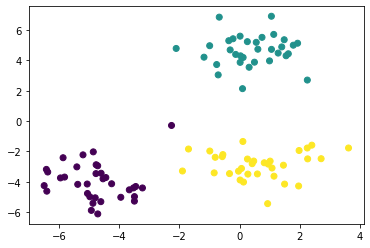

In [5]:
plt.scatter(x = data[:, 0], y = data[:, 1], c = lbls)

## Реализация ##

Здесь не совсем Kmedoids, по сути, ибо здесь только один раз случайно инициализируются кластеры и не происходит сходимости. По сути, здесь всего один проход по данным, но есть одно серьезное допущение - что в классах одинаковое количество элементов.

In [6]:
class Kmedoids_1_iter():
    def __init__(self, n_classes = 2):
        self.n_classes = n_classes
        
    def mse(self, a, b):
        a = np.array(a)
        b = np.array(b)
        return (sum((a - b)**2))**.5
    
    def fit_predict(self, X):
        # инициализация медоидов
        medoids_indexes = np.random.randint(low = 0, high = X.shape[0], size = self.n_classes)
        self.medoids = {num_of_medoid: X[idx] for num_of_medoid, idx in enumerate(medoids_indexes)}
        # print(medoids)
        
        # инициализация данных с классами
        data_with_classes = np.column_stack([X, range(0, X.shape[0]), np.zeros(X.shape[0])]) 
        # данные (n features), номер, метка (0 - отсутствие метки)
        
        # равенство количества точек в классах
        n_samples_in_class = data_with_classes.shape[0] // self.n_classes
        
        # теперь надо отнести к этим n типам все остальные образцы
        # пусть ближайшие - на определенном расстоянии
        # посчитать матрицу расстояний
        for key, medoid in self.medoids.items(): # для каждого медоида 
            distance_for_medoid = []
            for idx in range(len(data_with_classes)): # посчитать R до каждой точки
                #print(point, point[:-2])
                if (data_with_classes[idx][-1] == 0): # для нераспределенных
                    distance_for_medoid.append( [self.mse(medoid, data_with_classes[idx][:-2]),
                                                 data_with_classes[idx][-2], data_with_classes[idx][-1]] )
            
            distance_for_medoid = sorted(distance_for_medoid)[:n_samples_in_class]
            distance_for_medoid = np.array(distance_for_medoid)
            
            # теперь можно заполнить
            for idx in range(len(data_with_classes)):
                if idx in distance_for_medoid[:,-2]:
                    data_with_classes[idx][-1] = key

        return data_with_classes

## Тестирование ## 

Тестирование на игрушечный датасетах

Простой датасет

In [7]:
km = Kmedoids_1_iter(3)
y_pred = km.fit_predict(data)

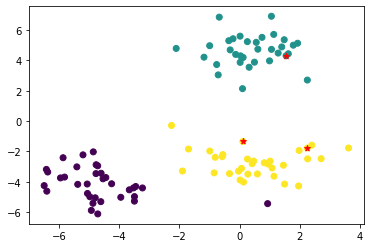

In [10]:
plt.scatter(y_pred[:, 0], y_pred[:, 1], c = y_pred[:, 3], marker = 'o')
plt.scatter(np.array(list(km.medoids.values()))[:,0], np.array(list(km.medoids.values()))[:,1], marker = '*', color = 'red')

Более сложный датасет

In [16]:
X_2 = make_classification(n_samples = 100,)

In [17]:
data_2 = np.column_stack([X_2[0][:,0], X_2[0][:,1]])
lbls_2 = X_2[1]

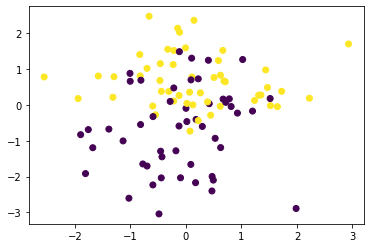

In [18]:
plt.scatter(x = data_2[:, 0], y = data_2[:, 1], c = lbls_2)

In [19]:
km_2 = Kmedoids_1_iter(2)
y_pred_2 = km_2.fit_predict(data_2)

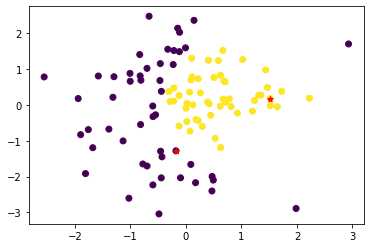

In [20]:
plt.scatter(x = data_2[:, 0], y = data_2[:, 1], c = y_pred_2[:, 3])
plt.scatter(np.array(list(km_2.medoids.values()))[:,0], np.array(list(km_2.medoids.values()))[:,1], marker = '*', color = 'red')

Можно попробовать что-то линейно неразделимое

In [21]:
X_3 = make_circles(n_samples = 100,)

In [22]:
data_3 = np.column_stack([X_3[0][:,0], X_3[0][:,1]])
lbls_3 = X_3[1]

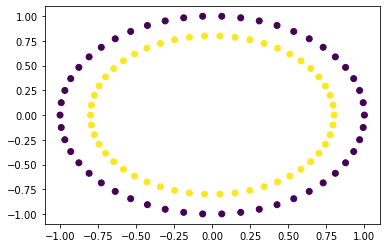

In [23]:
plt.scatter(x = data_3[:, 0], y = data_3[:, 1], c = lbls_3)

In [24]:
km_3 = Kmedoids_1_iter(2)
y_pred_3 = km_3.fit_predict(data_3)

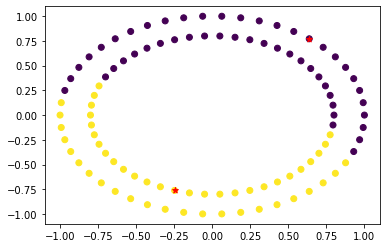

In [25]:
plt.scatter(x = data_3[:, 0], y = data_3[:, 1], c = y_pred_3[:, 3])
plt.scatter(np.array(list(km_3.medoids.values()))[:,0], np.array(list(km_3.medoids.values()))[:,1], marker = '*', color = 'red')

Не очень удачная инициалиация, так что можно попробовать еще раз

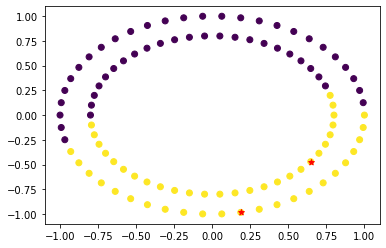

In [26]:
km_4 = Kmedoids_1_iter(2)
y_pred_4 = km_4.fit_predict(data_3)
plt.scatter(x = data_3[:, 0], y = data_3[:, 1], c = y_pred_4[:, 3])
plt.scatter(np.array(list(km_4.medoids.values()))[:,0], np.array(list(km_4.medoids.values()))[:,1], marker = '*', color = 'red')

Здесь видно, что из-за того, что берутся медоиды, т.е. координаты существующих точек, попасть в центр невозможно, поэтому классификатор работает криво

**Далее - что-то более похожее на классический алгоритм K-медоидов: сначала центры кластеров инициализируются, а потом сходятся ближе к истинным центрам кластеров**

## Реализация алгоритма со сходимостью ##

На самом деле, здесь нужно еще переписать немного, ибо работает криво

In [27]:
class KMedoids():
    def __init__(self, n_classes = 2, eps = 1):
        self.n_classes = n_classes
        self.eps = 10
        
    def mse(self, a, b):
        a = np.array(a)
        b = np.array(b)
        return (sum((a - b)**2))**.5
    
    def current_inertia(self, data_with_classes):
        self.inertia = 0
        for i_class in range(self.n_classes):
            # print(data_with_classes[data_with_classes[:,-2] == i_class][:, :-2])
            inner_class_inertia = sum((sum((data_with_classes[data_with_classes[:,-2] == i_class][:, :-2])**2))**.5)
            self.inertia += inner_class_inertia
    
    def find_median(self, data_with_classes_for_1_class):
        return np.median(data_with_classes_for_1_class, axis = 0)
    
    def calculate_distance(self, data_with_classes, n_samples_in_class):
        # ИНИЦИАЛИЗАЦИЯ
        # теперь надо отнести к этим n типам все остальные образцы
        # пусть ближайшие - на определенном расстоянии
        # посчитать матрицу расстояний
        for key, medoid in self.medoids.items(): # для каждого медоида 
            distance_for_medoid = []
            # print(len(self.medoids.items()))
            for idx in range(len(data_with_classes)): # посчитать R до каждой точки
                #print(point, point[:-2])
                if (data_with_classes[idx][-1] == 0): # для нераспределенных
                    # print(medoid,'_____', data_with_classes[idx][:-2], )
                    distance_for_medoid.append( [self.mse(medoid, data_with_classes[idx][:-2]),
                                                 data_with_classes[idx][-2], data_with_classes[idx][-1]] )
            
            distance_for_medoid = sorted(distance_for_medoid)[:n_samples_in_class]
            distance_for_medoid = np.array(distance_for_medoid)
            
            # теперь можно заполнить
            for idx in range(len(data_with_classes)):
                if idx in distance_for_medoid[:,-2]:
                    data_with_classes[idx][-1] = key
        return data_with_classes
        
    def fit_predict(self, X):
        # инициализация медоидов
        medoids_indexes = np.random.randint(low = 0, high = X.shape[0], size = self.n_classes)
        self.medoids = {num_of_medoid: X[idx] for num_of_medoid, idx in enumerate(medoids_indexes)}
        
        # инициализация данных с классами
        data_with_classes = np.column_stack([X, range(0, X.shape[0]), np.zeros(X.shape[0])]) 
        # данные (n features), номер, метка (0 - отсутствие метки)
        
        # равенство количества точек в классах
        n_samples_in_class = data_with_classes.shape[0] // self.n_classes
        
        # НАЧАЛЬНАЯ ИНИЦИАЛИЗАЦИЯ
        data_with_classes = self.calculate_distance(data_with_classes, n_samples_in_class)
        
        # СХОДИМОСТЬ
        diff = 1e10
        # теперь можно перейти к движению медоидов
        # пока разница между проходами больше условия
        while (diff > self.eps):
            self.current_inertia(data_with_classes)
            pred_inertia = self.inertia
            #print(pred_inertia)
            
            
            # пересчет медиан
            self.medoids = {}
            for i_class in range(self.n_classes):
                self.medoids[i_class] = self.find_median(data_with_classes[data_with_classes[:,-2] == i_class])[:-2]
                
            data_with_classes = self.calculate_distance(data_with_classes, n_samples_in_class)
            
            self.current_inertia(data_with_classes)
            new_inertia = self.inertia
            diff = new_inertia - pred_inertia
            
        return data_with_classes

In [28]:
kmedoids = KMedoids(3)
y_pred_km = kmedoids.fit_predict(data)

In [29]:
np.array(list(kmedoids.medoids.values()))

array([[-4.92730154, -5.89066274],
       [-3.22914061, -4.41059182],
       [ 1.78153268,  5.00186799]])

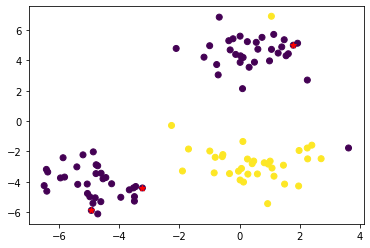

In [30]:
plt.scatter(y_pred_km[:, 0], y_pred_km[:, 1], c = y_pred_km[:, 3], marker = 'o')
plt.scatter(np.array(list(kmedoids.medoids.values()))[:,0], np.array(list(kmedoids.medoids.values()))[:,1], marker = '*', color = 'red')

Что-то очень кривое, возможно, надо использовать радиусы для каждого медоида другие.